# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Colab Notebooks/COMPUTER VISION IN DEEP LEARNING IMPLEMENTATION AND ITS APPLICATIONS')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


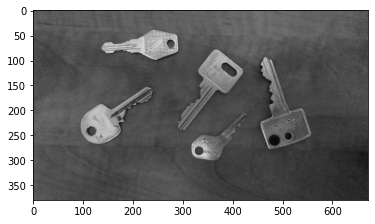

image.shape:  (380, 672)


In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("/content/drive/MyDrive/Colab Notebooks/COMPUTER VISION IN DEEP LEARNING IMPLEMENTATION AND ITS APPLICATIONS/sample_image/keys.png",0)
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)


## Step 1. Gaussian filter

In [17]:
def plot_different(i1,n1,i2,n2):
  # fig = plt.figure(figsize=(12,9))
  # fig.subplots_adjust(hspace=0.2, wspace=0.2)
  fig = plt.figure(figsize=(20,12))
  fig.subplots_adjust(hspace=0.1, wspace=0.1)

  plt.subplot(1,2,1)
  plt.imshow(i1 ,cmap='gray')
  plt.title(n1)

  plt.subplot(1,2,2)
  plt.imshow(i2 ,cmap='gray')
  plt.title(n2)

  plt.show()

input shape : (380, 672)
padding shape : (382, 674)


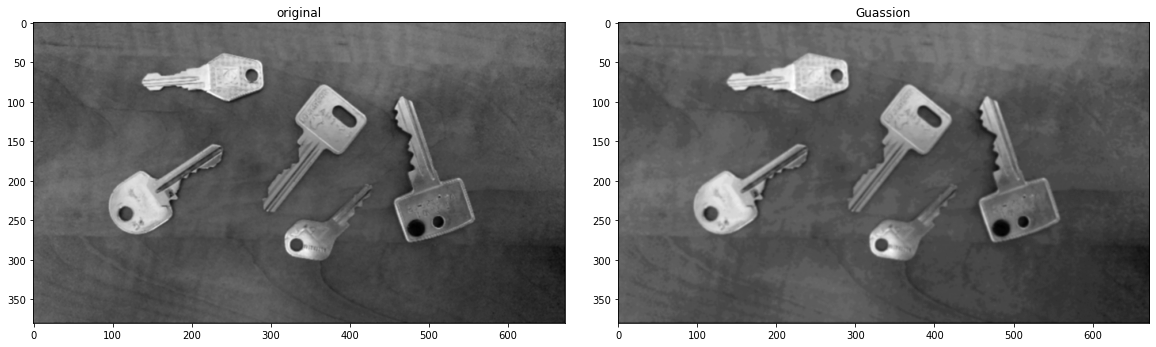

In [35]:
def padding_img(img,p_size,style='edge'):
  # ------------ To do ------------- #
  row, col = img.shape
  print(f'input shape : {img.shape}')
  pad_img = np.zeros((row+2*p_size,col+2*p_size)).astype('int32')
  for i in range(row):
    for j in range(col):
      pad_img[i+p_size][j+p_size] += img[i][j]
  print(f'padding shape : {pad_img.shape}')
  return pad_img.astype('int32')

def gaussian_kernel(size):
  # ------------ To do ------------- #
  sigma = 0.3*((KernelSize-1)*0.5 - 1) + 0.8
  Gaussian=[]
  #各係數相加後總值
  total=0
  center = KernelSize/2
  for i in range(0,KernelSize):
      Filter_list = []
      for j in range(0,KernelSize): 
          #高斯函數公式
          # -------------- To do ----------------- #
          matrix_value = (math.e**(-((i-math.floor(KernelSize/2))**2+(j-math.floor(KernelSize/2))**2)/(2*sigma**2)))/(2*math.pi*sigma**2)
          Filter_list.append(matrix_value)
          total += matrix_value
      Gaussian+= [Filter_list]     
  return np.array(Gaussian)/total
KernelSize = 3

def Gaussian_Filter(KernelSize,image):
    row,col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    # ------------ To do ------------- #

    for r in range(row):
      for c in range(col):
        for i in range(KernelSize):
          for j in range(KernelSize):
            resx[r,c]+= padimg[r+i,c+j]* Gaussian_Kernel[i][j]
    return resx

img_G = Gaussian_Filter(KernelSize,img_org.copy())
plot_different(img_org,"original",img_G,'Guassion')

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [47]:
def sobel(img, filtering_type):
    row, col = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
    Gx = np.zeros((row - 2, col - 2))
    Gy = np.zeros((row - 2, col - 2))

    conv_img = img.copy()
    # ------------ To do ------------- #
    for r in range(row-2):
      for c in range(col-2):
        for i in range(3):
          for j in range(3):
            if filtering_type == 'horizontal':
              Gx[r,c] += conv_img[r+i,c+j]* horizontal[i][j]
            elif filtering_type == 'vertical':
              Gy[r,c] += conv_img[r+i,c+j]* vertical[i][j]
            elif filtering_type == 'magnitude':
              Gx[r,c] += conv_img[r+i,c+j]* horizontal[i][j]
              Gy[r,c] += conv_img[r+i,c+j]* vertical[i][j]

    gradient = np.sqrt(Gx**2 + Gy**2)
    gradient = np.pad(gradient, (1, 1), 'constant')
    angle = np.arctan2(Gy, Gx)
    angle = np.pad(angle, (1, 1), 'constant')

    output = (255 * np.int32(gradient > 255) + gradient * np.int32(gradient <= 255))
    angle += math.pi * np.int32(angle < 0)


    return output, angle

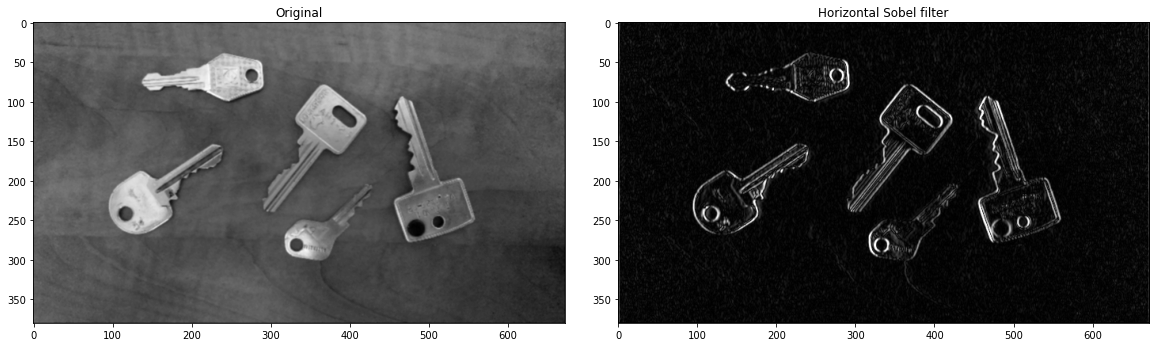

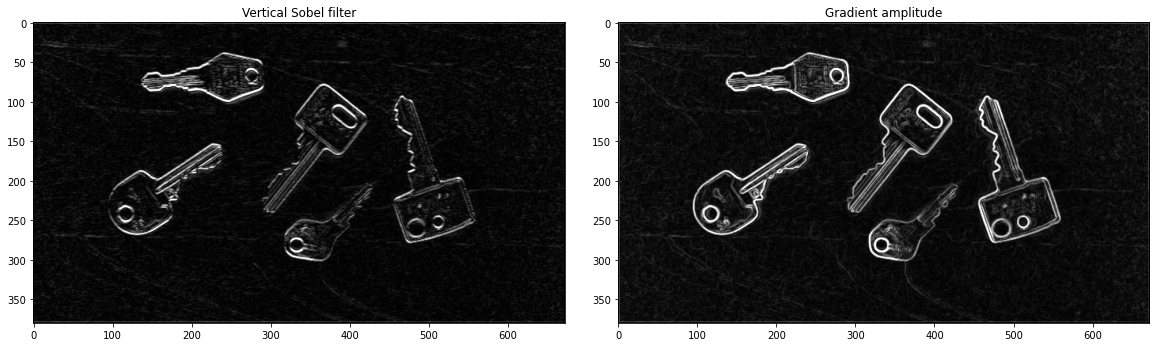

In [48]:
# ------------ To do ------------- #
sobel_y,_ = sobel(img_org.copy(), 'horizontal')
sobel_x,_ = sobel(img_org.copy(), 'vertical')
sobel_m,_ = sobel(img_org.copy(), 'magnitude')

plot_different(img_org,'Original',sobel_y,'Horizontal Sobel filter')
plot_different(sobel_x,'Vertical Sobel filter',sobel_m,'Gradient amplitude')


## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [58]:
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape

    degree={
        '0':{'-':0,'+':22.5 / 180 * math.pi},
        '45':{'-':22.5 / 180 * math.pi,'+':67.5 / 180 * math.pi},
        '90':{'-':67.5 / 180 * math.pi,'+':112.5 / 180 * math.pi},
        '135':{'-':112.5 / 180 * math.pi,'+':157.5 / 180 * math.pi},
        '180':{'-':157.5 / 180 * math.pi,'+':math.pi}
    }

    for j in range(1, height-1):
        for i in range(1, width-1):
          # ------------ To do ------------- #
          #0~22.5 / 157.5~180
          if (angle[j, i] >= degree['0']['-'] and angle[j, i] < degree['0']['-']) or (angle[j, i] >= degree['180']['-'] and angle[j, i] < degree['180']['-']):
              if gradient[j, i] < gradient[j, i-1] or gradient[j, i] < gradient[j, i+1]:
                  gradient_copy[j, i] = 0
          #22.5~67.5
          elif angle[j, i] >= degree['45']['-'] and angle[j, i] < degree['45']['+']:
              if gradient[j, i] < gradient[j-1, i-1] or gradient[j, i] < gradient[j+1, i+1]:
                  gradient_copy[j, i] = 0
          #67.5~112.5
          elif angle[j, i] >= degree['90']['-'] and angle[j, i] < degree['90']['-']:
              if gradient[j, i] < gradient[j-1, i] or gradient[j, i] < gradient[j+1, i]:
                  gradient_copy[j, i] = 0
          #112.5~157.5
          elif angle[j, i] >= degree['135']['-'] and angle[j, i] < degree['135']['-']:
              if gradient[j, i] < gradient[j+1, i-1] or gradient[j, i] < gradient[j-1, i+1]:
                  gradient_copy[j, i] = 0  
                           
    return gradient_copy

gradient,angle = sobel(img_org, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)


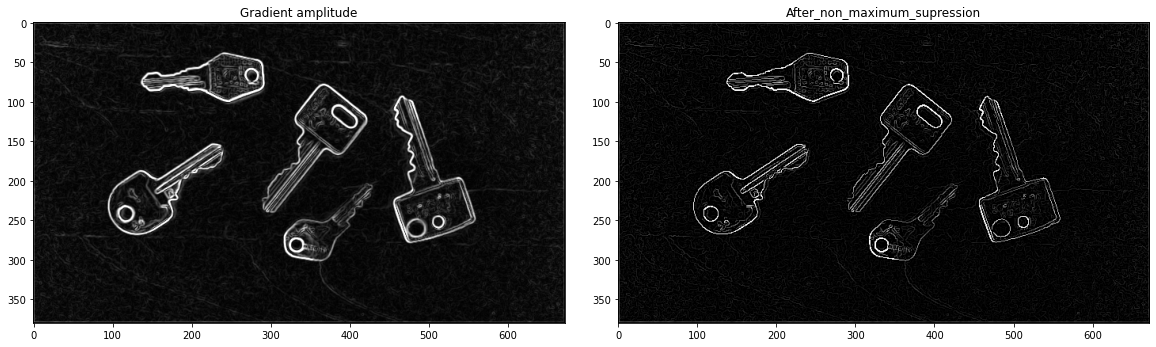

In [ ]:
# ------------ To do ------------- #
plot_different(sobel_m,'Gradient amplitude',After_non_maximum_supression,'After_non_maximum_supression')

## Step 4. Thresholding edges

In [78]:
def seperate(img, minimum = 60, maximum = 180):
    # ------------ To do ------------- #
    output = img.copy()
    output[(output<maximum)*(output>=minimum)]=minimum
    output[output>=maximum]=255
    output[output<minimum] = 0   
    return output
min = 60
thresholding = seperate(After_non_maximum_supression, minimum = min, maximum = min*3)

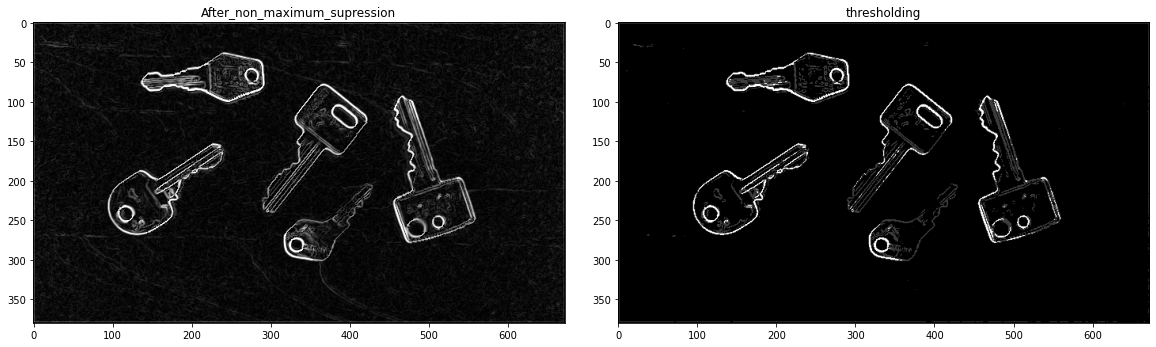

In [79]:
# ------------ To do ------------- #
plot_different(After_non_maximum_supression,'After_non_maximum_supression',thresholding,'thresholding')

## Step 5. Hysteresis

In [80]:
def Connect(img,weak=60):
  # ------------ To do ------------- #
  height,width = img.shape
  output = img.copy()
  strong_x,strong_y = np.where(img == 255)
  strong_x = strong_x.tolist()
  strong_y = strong_y.tolist()
  while len(strong_x) >0:
    point_x = strong_x.pop()
    point_y = strong_y.pop()
    if (point_x+1 <= height and point_x-1>=0) and (point_y+1<=width and point_y-1>=0):
      newx,newy = np.where(output[point_x-1: point_x+1+1,point_y-1:point_y+1+1]==weak)
      newx = newx+point_x-1
      newy = newy+point_y-1    
      if len(newx)>0:
        output[newx,newy]=255
        strong_x = newx.tolist() + strong_x
        strong_y = newy.tolist() + strong_y
  output[output==weak]=0

  return output
dst_img = Connect(thresholding,weak=min)


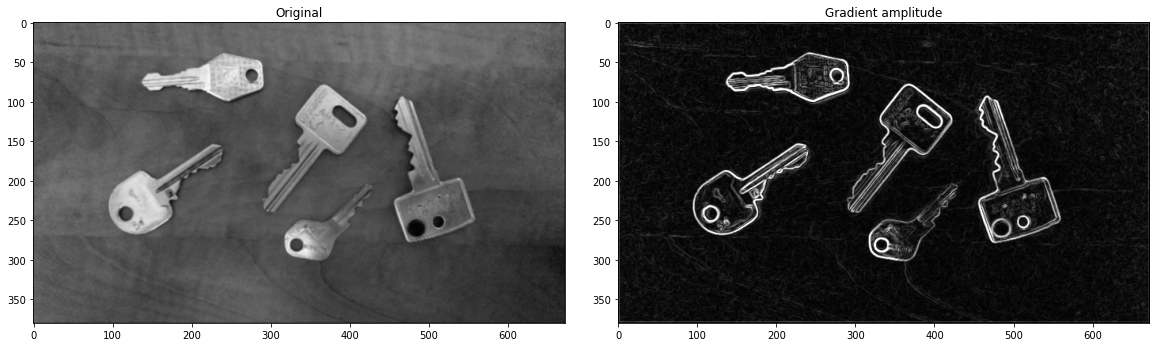

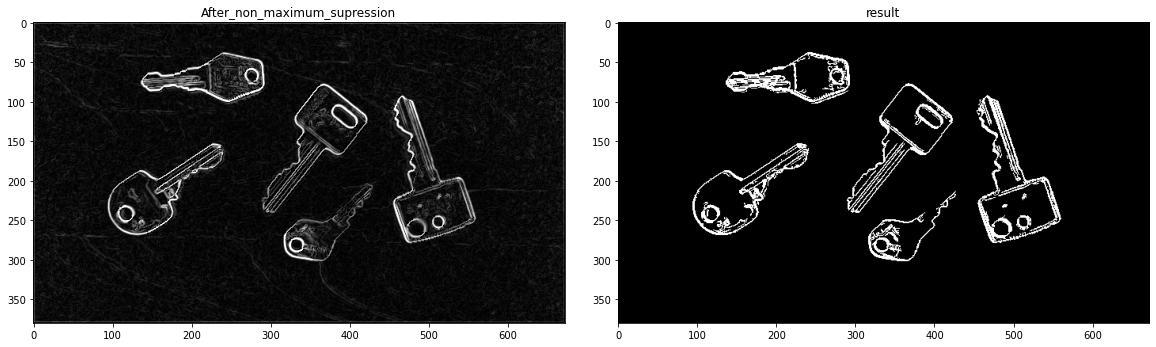

In [81]:
# ------------ To do ------------- #
plot_different(img_org,'Original',sobel_m,'Gradient amplitude')
plot_different(After_non_maximum_supression,'After_non_maximum_supression',dst_img,'result')

# Canny Edge OpenCV 套件


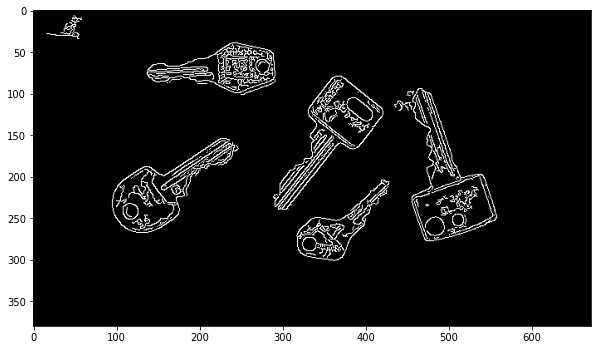

In [82]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/COMPUTER VISION IN DEEP LEARNING IMPLEMENTATION AND ITS APPLICATIONS/sample_image/keys.png",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

# 加分討論：為什麼和套件不一樣？

因為.....